# Lumen Data Science

PyTissue

Update or install important libraries

In [10]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa

In [11]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
from IPython.display import Audio
from IPython.utils import io
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

## Label getters

In [12]:
train_path = Path("./Dataset/Dataset/IRMAS_Training_Data")
noise_path = Path("./Dataset/Dataset/IRMAS_Training_Data/noi")
valid_path = Path("./Dataset/Dataset/IRMAS_Validation_Data")
test_path = Path("./Dataset/Dataset/IRMAS_Test_Data")
grand_path = Path("./Dataset/Dataset")

In [13]:
get_song_files = FileGetter(extensions='.wav', recurse=True)

In [14]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
def is_IRMAS_test(pat: Path):
    return str(pat).find("IRMAS_Test_Data") != -1

song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

In [15]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = Path("./Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")
get_IRMAS_train_label(song_path)

['cel']

In [16]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_IRMAS_valid_label(song_path)

['gel', 'voi']

In [17]:
def get_label(pat: Path):
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    return get_IRMAS_valid_label(pat)

def get_single_label(pat: Path):
    return get_label(pat)[:1]

song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_label(song_path)

['gel', 'voi']

## Analyze the dataset

In [18]:
avg = np.average([len(get_label(f)) for f in get_song_files(valid_path)])
print("Average insruments: ", avg)

# Average accuracy when model outputs only zeros
all_z_ac = 1 - avg/11
print("All zeros model:", all_z_ac)

# If model can classify one instrument with accuracy
# of ac, then total accuracy will be less than:
ac = 0.95
one_l_ac = ac * (1 - (avg - 1)/11) + (1-ac) * (1 - (avg + 1)/11)
print(f"One label model ({ac}):", one_l_ac)


# if model can classify 1.7 instruments with accuracy
# of ac, and miss them otherwise:
ac = 0.85
all_l_ac = ac * (1 - (avg - avg)/11) + (1-ac) * (1 - (avg *2)/11)
print(f"All model: ({ac})", all_l_ac)

# That means our model needs to have much bigger accuracy 
# than the first and we would strive for the second

Average insruments:  1.778301886792453
All zeros model: 0.838336192109777
One label model (0.95): 0.9201543739279587
All model: (0.85) 0.9515008576329331


## Get items

In [19]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

In [20]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]
class ToSong(Transform):
    def encodes(self, song):
        if isinstance(song, Path):
            return get_song(song)
        return song

In [21]:
def extend_to_3sr(song):
    aplen = sample_rate*3 - len(song)
    if aplen < 0: aplen = 0
    song = np.concatenate([song, np.zeros(aplen, dtype="float32")])
    return song
    

In [22]:
class RandomClip(Transform):
    split_idx=0
    def encodes(self, song):
        maxran = len(song)-sample_rate*3 + 1
        if maxran <= 0: maxran = 1

        i = np.random.randint(maxran)
        # i=0
        song = song[i:i+sample_rate*3]
        return extend_to_3sr(song)
        
class CenterClip(Transform):
    split_idx=1
    def encodes(self, song):
        i = int((len(song) - sample_rate*3) / 2)
        song = song[i:i+sample_rate*3]
        return extend_to_3sr(song)

random_clip = RandomClip().encodes
center_clip = CenterClip().encodes

In [24]:
def get_spec(song):
    stft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return S_db

In [25]:
def get_mag(song):
    M = librosa.feature.melspectrogram(y=song, sr=sample_rate)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

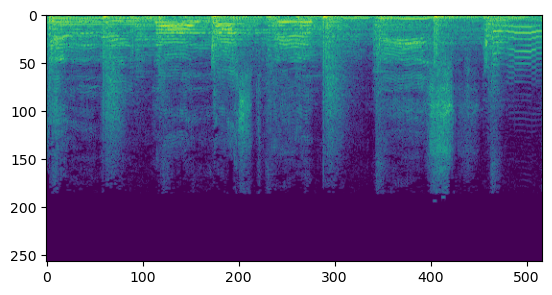

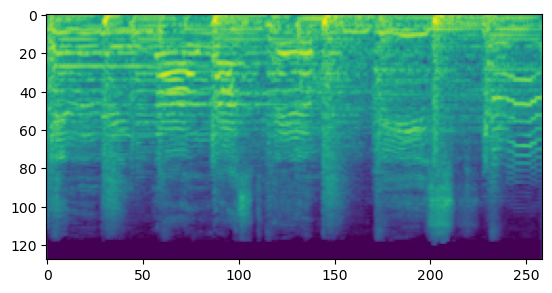

In [26]:
song_path = Path("./Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")

spec = get_spec(center_clip(get_song(song_path)))
plot.figure()
plot.imshow(spec)
spec = get_mag(center_clip(get_song(song_path)))
plot.figure()
plot.imshow(spec)

## Metrics

In [27]:
def AccuracyMulti(tresh=0.5):
    def acc(x, y):
        return 1 - (((x > tresh).float() - y).abs()).float().mean()
    return acc
AccuracyMulti()(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Building the model

In [28]:
get_song_tfms = [ToSong(), RandomClip(), CenterClip()]
get_label_tfms = [get_label, MultiCategorize(), OneHotEncode()]
get_single_label_tfms = [get_single_label, Categorize()]

get_spec_tfms = [get_spec, PILImage.create]
get_mag_tfms = [get_mag, PILImage.create]

In [29]:
def get_subset(x, p=0.9):
    return [x[i] for i in RandomSplitter(p)(x)[0]]

In [30]:
class AddRandomSongs(ItemTransform):
    split_idx = 0
    def __init__(self, items, augm=[], num=1, perc=0.5):
        self.items = np.array(items)
        self.get_song_pipe = Pipeline(get_song_tfms)
        self.augm_pipe = Pipeline(augm)
        self.get_label_pipe = Pipeline(get_label_tfms)
        self.num = num
        self.perc = perc
    
    def get_random_songs(self, k):
        files = np.random.choice(self.items, k)
        self.augm_pipe.split_idx = 0
        self.get_song_pipe.split_idx = 0
        X = [self.augm_pipe([self.get_song_pipe(f)])[0] for f in files]
        Y = [self.get_label_pipe(f) for f in files]
        return X, Y
        
    def encodes(self, item):
        if np.random.rand() >= self.perc: return item
        x, y = item
        l = np.random.poisson(self.num)
        X, Y = self.get_random_songs(l)
        X.append(x)
        Y.append(y)
        x = sum(X)
        y = TensorMultiCategory([min(i, 1) for i in sum(Y)])
        return [x, y]

In [31]:
class PitchShift(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5):
        self.perc=perc
        
    def encodes(self,item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        n_steps = np.random.rand()*10-5
        x = librosa.effects.pitch_shift(x,sr=sample_rate, n_steps=n_steps)
        return [x] + item[1:]

In [32]:
class GaussianNoise(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5):
        self.perc=perc
        
    def encodes(self,item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        noise = np.random.randn(len(x))
        x = x + 0.005*noise
        return [x] + item[1:]

In [33]:
class RandomRotate(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(self.l*sample_rate)
        i = np.random.randint(-maxran, maxran+1)
        x = np.roll(x, i)
        return [x] + item[1:]

In [34]:
class RandomEdgeSilence(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(sample_rate*self.l)
        i = np.random.randint(-maxran, maxran+1)
        if i < 0: x[i:] = 0
        else: x[:i] = 0
        return [x] + item[1:]

In [35]:
class RandomAmp(ItemTransform):
    split_idx = 0
    def __init__(self, rng=[0.6,2]):
        self.rng = rng
    def encodes(self, item):
        x = item[0]
        x = x * np.random.uniform(self.rng[0], self.rng[1])
        return [x] + item[1:]

In [36]:
class ToSpec(ItemTransform):
    def __init__(self, tfms):
        self.pipe = Pipeline(tfms)
    def encodes(self, item):
        x = item[0]
        return [self.pipe(x)] + item[1:]

In [37]:
class ShowSong(ItemTransform):
    split_idx = 0
    def __init__(self, k=10):
        self.cnt = 0
        self.k = k
    def encodes(self, item):
        x, y = item
        if self.cnt < self.k + 1:
            if 0 < self.cnt:
                display(y)
                display(Audio(data=x, rate=sample_rate))
            self.cnt += 1
        return item

In [38]:
def get_dataset(items, splitter=RandomSplitter()):
    splits = splitter(items)
    return Datasets(items, [get_song_tfms, get_label_tfms], splits=splits)

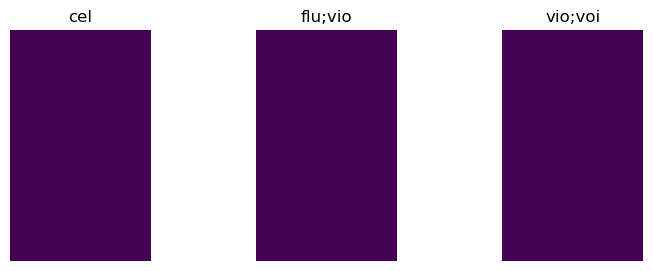

In [50]:
splitter = FuncSplitter(lambda x: is_IRMAS_test(x))
items = get_song_files(grand_path)
train_dset = get_dataset(items, splitter)
augm_items = get_song_files(train_path) # [train_dset.items[i] for i in train_dset.splits[0]]

augm = [
    RandomRotate(l=1.5),
    RandomEdgeSilence(l=1),
    PitchShift(perc=0.5),
    GaussianNoise(perc=0.6),
    RandomAmp(rng=[0.8,1.2])
]
after_augm = [
    AddRandomSongs(augm_items, augm=augm, num=2.5),
    ShowSong(3),
    ToSpec(get_spec_tfms),
    Resize((256, 156), method=ResizeMethod.Squish),
]

def get_dataloader(ds, augm=augm, after_augm=after_augm):
    after_item = augm + after_augm + [ToTensor(), IntToFloatTensor()]
    return ds.dataloaders(bs=64, after_item=after_item, shuffle=True)

dls = get_dataloader(train_dset)
dls.show_batch(max_n=3)

In [41]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
print(dls.vocab)
print(len(dls.vocab))

7341
2238
['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
11


In [46]:
learn = vision_learner(dls, resnet18, pretrained=True, metrics=AccuracyMulti(tresh=0.8))

In [47]:
learn = learn.load('MLBLCLA_model')

In [48]:
learn.validate()

(#2) [0.30292537808418274,0.8910554051399231]

In [187]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,acc,time
0,0.781949,0.442999,0.851125,02:19


epoch,train_loss,valid_loss,acc,time
0,0.508215,0.384117,0.860590,02:26
1,0.446415,0.378075,0.865505,02:27
2,0.415693,0.342985,0.870948,02:24
3,0.401005,0.346475,0.869973,02:27


In [192]:
# learn.export('laim_model.pkl')

## Track GPU usage

In [67]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [68]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [69]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [70]:
report_gpu()

Memory Usage:
Allocated: 0.3 GB
Cached:    1.8 GB


## Test on Validation data

In [62]:
def get_sl_windows(song, step=sample_rate):
    ran = range(0, len(song)-sample_rate-step, step)
    if len(ran) == 0: yield extend_to_3sr([0])
    for i in ran: 
        yield extend_to_3sr(song[i:i+sample_rate*3])

In [79]:
def predict(learn, song, step=sample_rate, tresh=0.8, perc=0.25):
    instr = np.zeros(len(learn.dls.vocab))
    for n, sl in enumerate(get_sl_windows(song)):
        with io.capture_output() as captured:
            instr[learn.predict(sl)[1] > tresh] += 1
    return learn.dls.vocab[instr > (n+1)*perc]

In [252]:
def validate(learn, tresh=0.5):
    preds = learn.get_preds()
    ms = np.array(np.logical_xor(preds[0] > 0.8, preds[1]), np.int32)
    fp = np.array(np.logical_and(ms, np.logical_not(preds[1])), np.int32)
    fn = np.array(np.logical_and(ms, preds[1]), np.int32)
    n = len(learn.dls.valid.items)
    return sum(fp) / n, sum(fn) /n

In [268]:
def print_validate(learn):
    fp, fn = validate(learn)
    for i in range(11):
        print(learn.dls.vocab[i], round(fp[i], 5), round(fn[i], 5))

In [269]:
print_validate(learn)

cel 0.00313 0.03619
cla 0.0 0.0277
flu 0.0 0.06077
gac 0.00268 0.14343
gel 0.00402 0.29491
org 0.01385 0.11215
pia 0.00581 0.2462
sax 0.00268 0.05853
tru 0.00938 0.03083
vio 0.00089 0.06345
voi 0.00626 0.15147


In [82]:
from datetime import datetime

def train(arch=resnet18, spec_tfms=get_spec_tfms, info= "...", tresh=0.8, epochs=16, pretrained=True):
    print("Setup:")
    print(info)
    print(arch, spec_tfms)
    augm = [
        RandomRotate(l=1.5),
        RandomEdgeSilence(l=1),
        PitchShift(perc=0.5),
        GaussianNoise(perc=0.6),
        RandomAmp(rng=[0.8,1.2])
    ]
    after_augm = [
        AddRandomSongs(augm_items, augm=augm, num=2.5),
        ToSpec(get_spec_tfms),
        Resize((256, 156), method=ResizeMethod.Squish),
    ]
    dls = get_dataloader(train_dset, augm=augm, after_augm=after_augm)
    learn = vision_learner(dls, arch, pretrained=pretrained, metrics=AccuracyMulti(tresh=tresh))
    learn.fine_tune(epochs)
    
    tim = datetime.now().strftime("%H_%M_%S")
    print(learn.save(f'{tim}_model'))
    report_gpu()

In [81]:
# avg all zeros 0.844467
# train(resnet18, tfms=get_spec_tfms, info="Resnet18 - with spectogram") # 0.844468
# train(resnet18, spec_tfms=get_mag_tfms, info="Resnet18 - with magspectogram", epochs=1) # 0.861833
train(squeezenet1_0, info="squeezenet1_0", epochs=16) # 862023
# train(densenet121, info="densenet121", epochs=16) # 0.844468 NOT WORKING???
train(vgg16_bn, info="vgg16_bn", epochs=16) # 0.871576
train(alexnet, info="alexnet", epochs=16) # 0.858227

Setup:
squeezenet1_0
<function squeezenet1_0 at 0x7f623ae1ce50> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,0.755899,0.674020,0.826834,02:06


epoch,train_loss,valid_loss,acc,time
0,0.527592,0.448445,0.846251,02:08
1,0.488709,0.802972,0.843123,02:07
2,0.476786,1.326348,0.850394,02:08
3,0.458942,2.979198,0.841336,02:10
4,0.442922,0.408169,0.856853,02:10
5,0.432857,0.417219,0.865667,02:06
6,0.416490,0.417862,0.857625,02:07
7,0.415891,0.432310,0.863677,02:08
8,0.410581,0.384453,0.859452,02:13
9,0.400298,0.389415,0.863393,02:11


models/16_51_48_model.pth
Memory Usage:
Allocated: 0.3 GB
Cached:    2.5 GB
Setup:
densenet121
<function densenet121 at 0x7f623af8d630> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,nan,nan,0.846210,02:25


epoch,train_loss,valid_loss,acc,time
0,nan,nan,0.846210,02:26
1,nan,nan,0.846210,02:26
2,nan,nan,0.846210,02:23
3,nan,nan,0.846210,02:23
4,nan,nan,0.846210,02:23
5,nan,nan,0.846210,02:23
6,nan,nan,0.846210,02:27
7,nan,nan,0.846210,02:24
8,nan,nan,0.846210,02:25
9,nan,nan,0.846210,02:26


models/17_33_03_model.pth
Memory Usage:
Allocated: 0.4 GB
Cached:    7.3 GB
Setup:
vgg16_bn
<function vgg16_bn at 0x7f623ae1e3b0> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,0.764368,0.419789,0.855106,04:02


epoch,train_loss,valid_loss,acc,time
0,0.520756,0.370748,0.866520,04:20
1,0.466925,0.371876,0.868876,04:21
2,0.424415,0.340800,0.876066,04:23
3,0.399789,0.351615,0.878869,04:22
4,0.378100,0.324880,0.889268,04:21
5,0.359006,0.314657,0.890284,04:20
6,0.339602,0.317148,0.892396,04:22
7,0.334285,0.288167,0.897595,04:22
8,0.324094,0.309500,0.895483,04:23
9,0.321131,0.309102,0.891015,04:21


models/18_48_28_model.pth
Memory Usage:
Allocated: 0.6 GB
Cached:    7.0 GB
Setup:
alexnet
<function alexnet at 0x7f623af28dc0> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,0.758053,0.461932,0.845113,02:11


epoch,train_loss,valid_loss,acc,time
0,0.534013,0.427251,0.851531,02:16
1,0.489807,0.411028,0.852912,02:08
2,0.467840,0.386797,0.855675,02:10
3,0.450230,0.406632,0.859412,02:10
4,0.435331,0.418562,0.853644,02:15
5,0.416431,0.363115,0.864124,02:13
6,0.412728,0.364101,0.860224,02:15
7,0.403153,0.365975,0.867739,02:18
8,0.394308,0.346459,0.867779,02:13
9,0.393195,0.361189,0.866033,02:13


models/19_26_22_model.pth
Memory Usage:
Allocated: 0.5 GB
Cached:    2.5 GB
